# Guia 5

Formación estelar / Datos SDSS y comparación con un semi-analítico


In [1]:
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns
import sys
sys.path.append('../')
from guia2.bimodal import fit_bimodal, normal, bimodal

## Constantes

In [2]:
CL = 'Cluster'
FD = 'Field'
SA = 'Semianalytic'

FILENAMES = {
    CL:'sample1_cls.dat',
    FD:'sample2_fd.dat',
    SA:'sample3_sim.dat'
}

COLUMNS = {
    CL:['cls', 'ra', 'dec', 'z',
        'Mr01', 'ur', 'mur', 'kr50',
        'C', 'stellarmass', 'sfr', 'ssfr',
        'Dn4000', 'class', 'Zc', 'sigma',
        'Mvir', 'Rvir', 'R200', 'w',
        'dist', 'Pe', 'Ps'
    ],
    FD:['ra', 'dec', 'z', 'Mr01',
        'ur', 'mur', 'kr50', 'C',
        'stellarmass', 'sfr', 'ssfr', 'Dn4000',
        'OH', 'w', 'Pe', 'Ps'
    ],
    SA:['cls', 'ig', 'type',  'clase',
        'stellarmass', 'u', 'g', 'r',
        'sfr', 'Mcoldgas', 'Mhotgas', 'Tau',
        'OH', 'bt', 'ssfr'
    ]
}

COLORS = {
    CL:'#7b3294',
    FD:'#008837',
    SA:'#ff7f00'
}

## Funciones

In [3]:
def fitbimodal_quantiles(data, col_fit='ur', col_q='Mr01', nquantiles=5):
    G = data[col_q]
    C_fit = data[col_fit]
    mask = []
    quantiles = []
    mean_x = []
    
    q = np.quantile(G, np.linspace(0.0,1.0,nquantiles+1)[1:-1])
    
    #print('data<q[0]')
    mask.append(G<q[0])
    quantiles.append(f'${G}<{q[0]:2.2f}$')
    mean_x.append(0.5*(G.min()+q[0]))
    for i in range(nquantiles-1):
        if i<nquantiles-2:
            #print(f'data>q[{i}] and data<q[{i+1}]')
            mask.append((G>q[i])&(G<q[i+1]))
            quantiles.append(f'${q[i]:2.2f}<{col_q}<{q[i+1]:2.2f}$')
            mean_x.append(0.5*(q[i]+q[i+1]))
        else:
            #print(f'data>q[{i}]')
            mask.append(G>q[i])
            quantiles.append(f'${col_q}>{q[i]:2.2f}$')
            mean_x.append(0.5*(q[i]+G.max()))

    fits = []
    for m in mask:
        fits.append(
            fit_bimodal(
                C_fit[m],
                p0=[0.5,1.5,0.3,0.5,2.5,0.2],
                nbins=50
            )
        )
    return mean_x, fits

## Catálogos

In [4]:
samples = {}
for n in [CL, FD, SA]:
    samples[n] = pd.read_fwf(FILENAMES[n], names=COLUMNS[n], skiprows=1)

In [5]:
# Agregar color u-r al semianalítico
COLUMNS[SA].append('ur')
COLUMNS[SA].append('gr')
samples[SA]['ur'] = samples[SA]['u']-samples[SA]['r']
samples[SA]['gr'] = samples[SA]['g']-samples[SA]['r']

In [6]:
# Quitando outliers
samples[CL].query('Rvir < 30 and C<4.5 and Dn4000<2.5 and Dn4000>0.5', inplace=True)
samples[FD].query('stellarmass > 8 and sfr > -8 and ur < 5 and kr50 < 20 and C < 5 and ur > 0 and Dn4000<2.5 and Dn4000>0.8 and Ps>0 and Pe>0', inplace=True)
samples[SA].query('Mhotgas != 99 and Mcoldgas != 99 and sfr!=99', inplace=True)

In [22]:
# Para automatizar el codigo, agrego una columna de "pesos" al semianalitico llena de 1
COLUMNS[SA].append('w')
samples[SA]['w'] = np.ones(len(samples[SA]['cls']))

## Propiedades de Clusters

In [7]:
cluster = samples[CL]

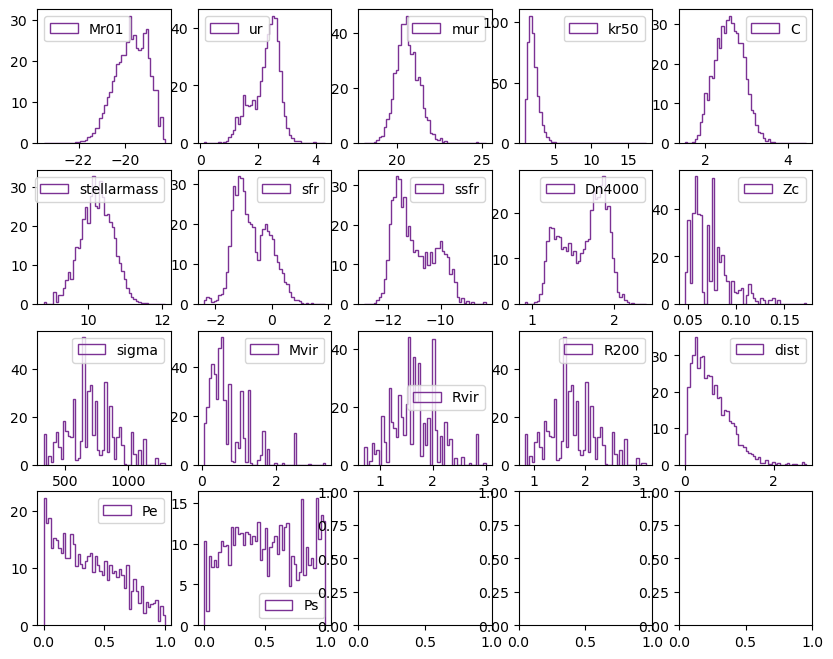

In [145]:
# Distribuciones de las columnas, pesadas por 'w'
fig, axes = plt.subplots(4,5,figsize=(10,8))
ax = axes.flatten()
i=0
for col in COLUMNS[CL]:
    if col=='cls': continue
    if col=='ra': continue
    if col=='dec': continue
    if col=='z': continue
    if col=='class': continue
    if col=='w': continue
    ax[i].hist(cluster[col], bins=50, weights=cluster['w'], histtype='step', color=COLORS[CL], label=col)
    ax[i].legend()
    i+=1

## Propiedades de Campo (?)

In [9]:
field = samples[FD]

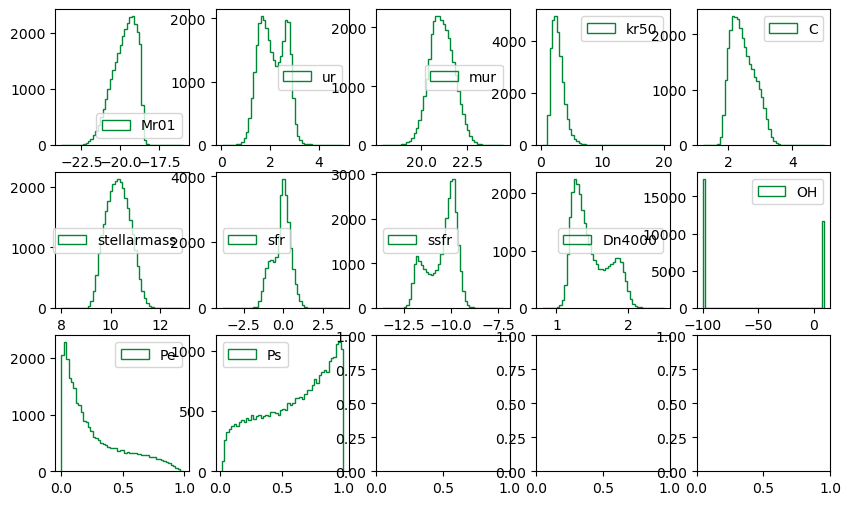

In [143]:
# Distribuciones de las columnas, pesadas por 'w'
fig, axes = plt.subplots(3,5,figsize=(10,6))
ax = axes.flatten()
i=0
for col in COLUMNS[FD]:
    if col=='ra': continue
    if col=='dec': continue
    if col=='z': continue
    if col=='w': continue
    ax[i].hist(field[col], bins=50, weights=field['w'], histtype='step', color=COLORS[FD], label=col)
    ax[i].legend()
    i+=1

## Propiedades Semianalítico

In [26]:
semia = samples[SA]

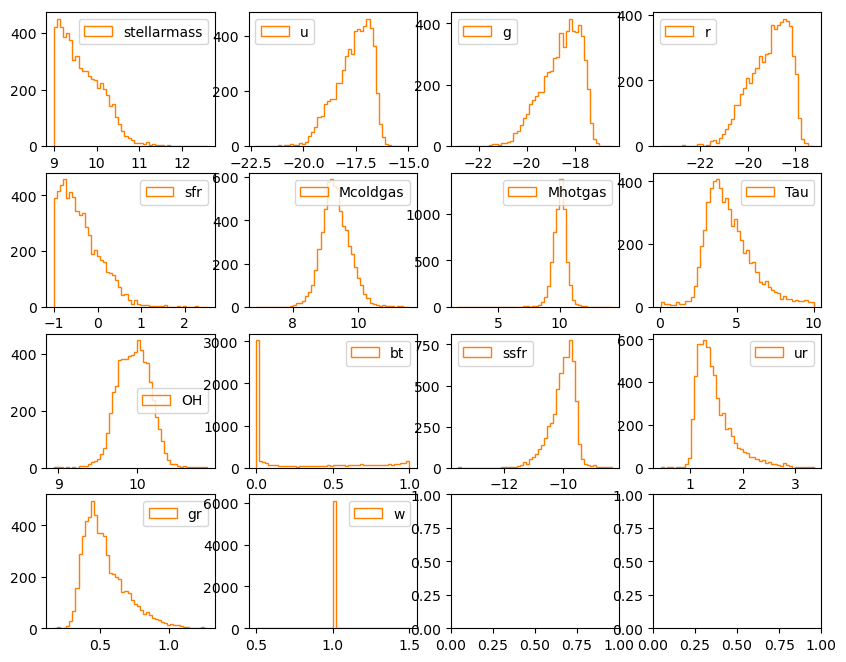

In [144]:
# Distribuciones de las columnas
fig, axes = plt.subplots(4,4,figsize=(10,8))
ax = axes.flatten()
i=0
for col in COLUMNS[SA]:
    if col=='cls': continue
    if col=='ig': continue
    if col=='type': continue
    if col=='clase': continue
    ax[i].hist(semia[col], bins=50, histtype='step', color=COLORS[SA], label=col)
    ax[i].legend()
    i+=1

## Comparación cluster-campo
Cluster y campo, semianalitico no tiene redshift

Distribución de redshift

Text(0.5, 0, 'Redshift')

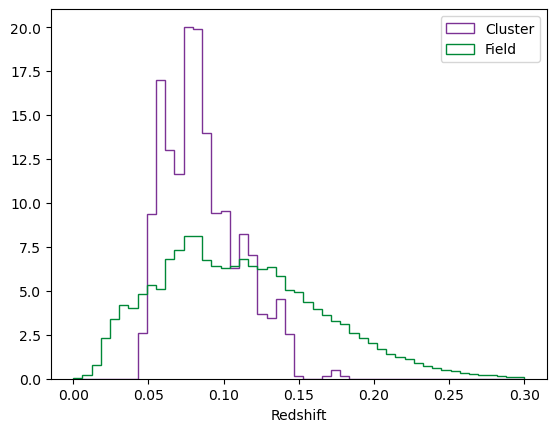

In [28]:
bins = np.linspace(0.0, 0.3, 50)

fig, ax = plt.subplots()
for n in [CL, FD]:
    ax.hist(
        samples[n]['z'],
        bins=bins, 
        density=True, 
        histtype='step', 
        label=n, 
        color=COLORS[n]
    )
ax.legend()
ax.set_xlabel('Redshift')

Completitud

/home/fmcaporaso/miniconda3/envs/envpy/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/fmcaporaso/miniconda3/envs/envpy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


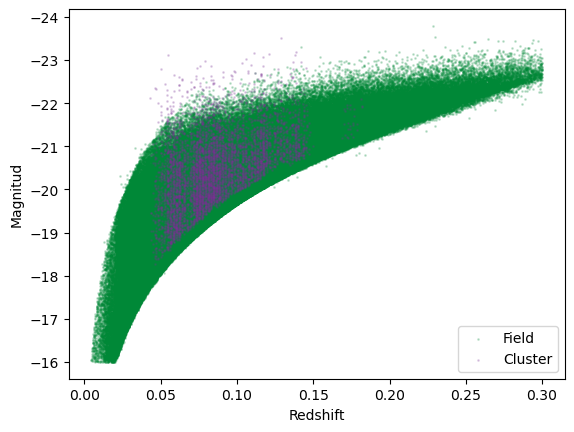

In [29]:
fig, ax = plt.subplots()

for i,n in enumerate([FD, CL]):
    ax.scatter(
        samples[n]['z'], samples[n]['Mr01'], 
        s=1, alpha=0.2, label=n, color=COLORS[n]
    )

ax.set_xlabel('Redshift')
ax.set_ylabel('Magnitud')
ax.invert_yaxis()
ax.legend()

Vemos que los catalogos de campo y cluster no son comparables, se debe realizar un corte en redshift para poder tomar muestras compatibles.

Para eso, se toman redshfits entre $0.05 \leq z \leq 0.14$, que son aproximadamente el rango donde tenemos clusters. Fuera del rango, sólo se tienen galaxias de campo. 

Además se utilizará una muestra completa por flujo, que implica pesar por $1/V_{\mathrm{max}}$ en las siguientes figuras.

In [30]:
z_cut = 'z > 0.05 and z < 0.14'

In [31]:
S = {} # Muestra que utilizaremos de aquí en adelante
for n in [CL,FD]:
    S[n] = samples[n].query(z_cut, inplace=False)
S[SA] = samples[SA]

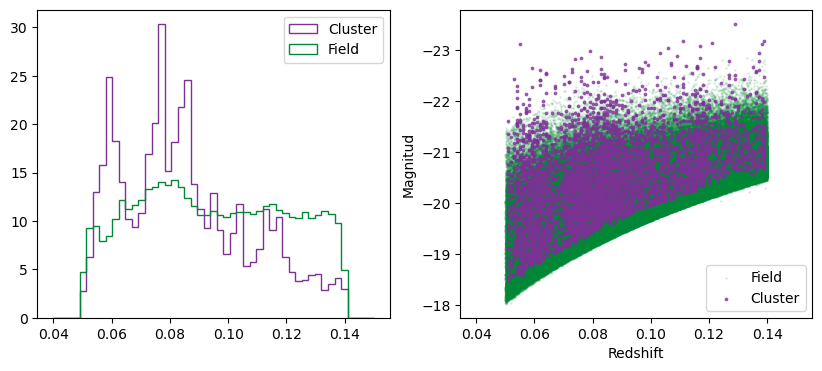

In [32]:
bins = np.linspace(0.04, 0.15, 50)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4),sharex=True)

for n in [CL, FD]:
    ax1.hist(
        S[n]['z'],
        bins=bins, 
        density=True, 
        histtype='step', 
        label=n, 
        color=COLORS[n]
    )
ax1.legend()

for i,n in enumerate([FD, CL]):
    ax2.scatter(
        S[n]['z'], S[n]['Mr01'], 
        s=1 if n==FD else 3, alpha=0.1 if n==FD else 0.7, 
        label=n, color=COLORS[n]
    )

ax2.set_xlabel('Redshift')
ax2.set_ylabel('Magnitud')
ax2.invert_yaxis()
ax2.legend()

### Distribución de masa estelar M$_{\star}$
Son comparables los dos catálogos?

pvalue = 5.01e-17
Las muestras son diferentes


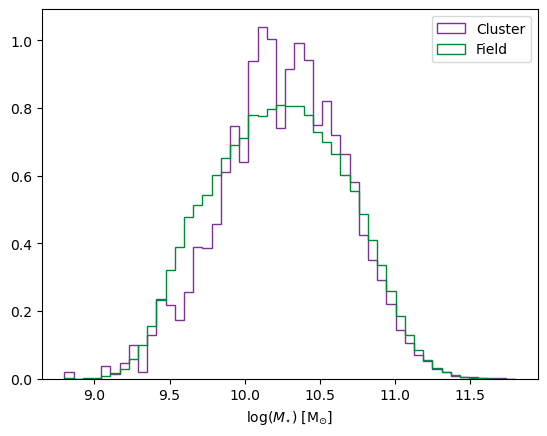

In [34]:
bins = np.linspace(8.8, 11.8, 50)
fig, ax = plt.subplots()

for n in [CL,FD]:
    ax.hist(
        S[n]['stellarmass'], 
        weights=S[n]['w'], 
        bins=bins, 
        density=True, 
        histtype='step', 
        label=n, 
        color=COLORS[n]
    )

ax.set_xlabel('$\log(M_{\star})$ [M$_{\odot}$]')
ax.legend();

# Son muestras similares?
ks_res = ks_2samp(S[CL]['stellarmass'], S[FD]['stellarmass'], method='exact')
print(f'pvalue = {ks_res.pvalue:2.2e}')
if ks_res.pvalue > 0.05:
    print('La información no es suficiente para rechazar la hip. nula')
else:
    print('Las muestras son diferentes')

El KS-test muestra que las distribuciones de masa estelar son diferentes, es decir, las masas de ambos catálogos son diferentes. Esto significa que debemos realizar un análisis por bines de masa.

De la figura anterior se puede ver que las galaxias de campo tienen un exceso de densidad en masas entre $9.5<\log M_{\star}<10$ respecto a las de cúmulo, mientras que estas ultimas tienen masas en el rango $10<\log M_{\star}<10.5$ de manera más frecuente que las de campo. 

In [58]:
# Separamos en n bines de masa
n_masa = 6
b_mstar = np.linspace(8.8,11.8,n_masa+1)
b_mstar = (b_mstar[:-1] + np.diff(b_mstar)*0.5)
print(b_mstar)

mstar = {}
for i in range(n_masa-1):
    massbin = f'{b_mstar[i]:2.1f}-{b_mstar[i+1]:2.1f}'
    mstar[massbin] = {}
    for n in [CL,FD]:
        mstar[massbin][n] = S[n].query(
            f'stellarmass > {b_mstar[i]} and stellarmass < {b_mstar[i+1]}', 
            inplace=False
        )

[ 9.05  9.55 10.05 10.55 11.05 11.55]


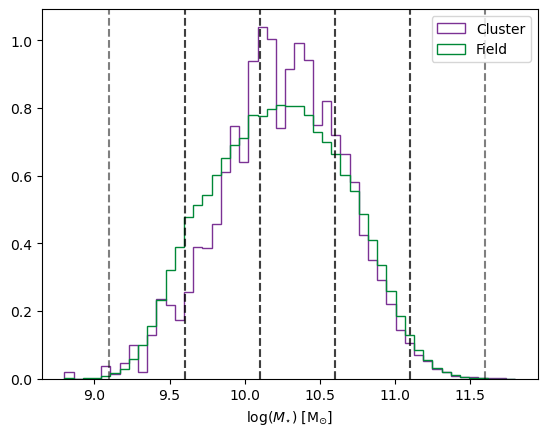

In [59]:
bins = np.linspace(8.8, 11.8, 50)
fig, ax = plt.subplots()

for n in [CL,FD]:
    ax.hist(
        S[n]['stellarmass'], 
        weights=S[n]['w'], 
        bins=bins, 
        density=True, 
        histtype='step', 
        label=n, 
        color=COLORS[n]
    )

for b in mstar.keys():
    ax.axvline(float(b.split('-')[0]), ls='--', color='k', alpha=0.5)
    ax.axvline(float(b.split('-')[1]), ls='--', color='k', alpha=0.5)

ax.set_xlabel('$\log(M_{\star})$ [M$_{\odot}$]')
ax.legend();

Text(0.5, 0, '$C$')

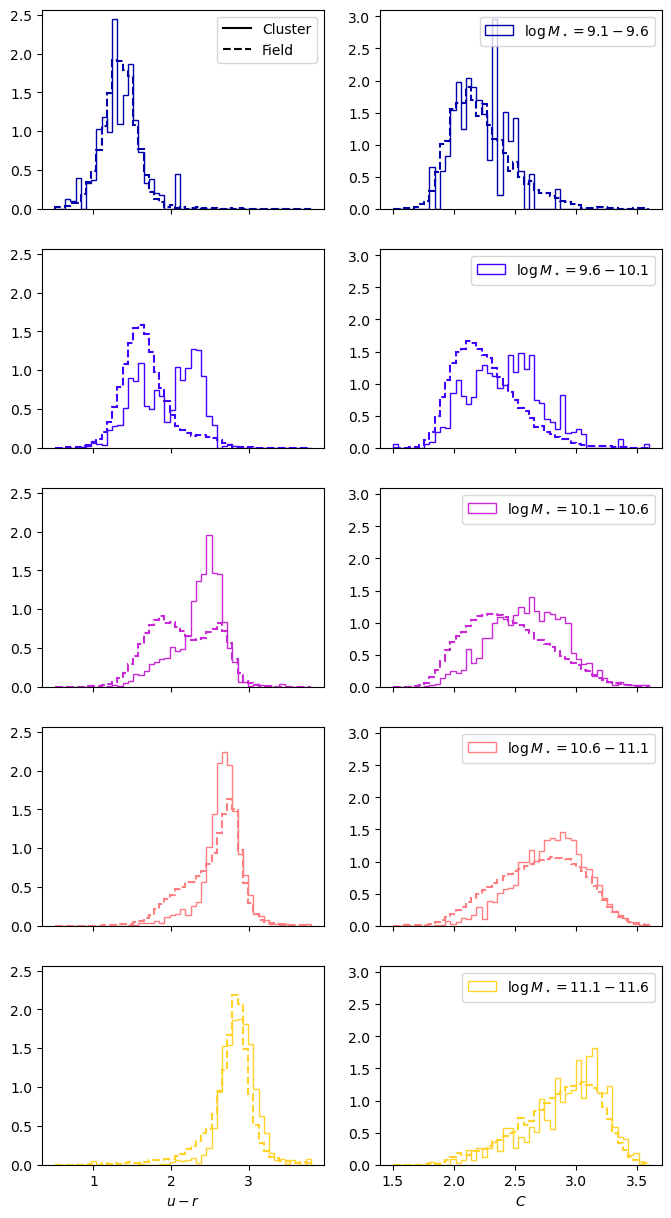

In [139]:
# Distribuciones de color de las dif masas
bins_ur = np.linspace(0.5,3.8,50)
bins_c = np.linspace(1.5,3.6,50)
cmap = plt.get_cmap('gnuplot2', n_masa+1)
fig, axes = plt.subplots(5,2,figsize=(8,15), sharex='col', sharey='col')

axes[0,0].plot([],[],color='k',label=CL)
axes[0,0].plot([],[],ls='--',lw=1.5,color='k',label=FD)
axes[0,0].legend()
i=0
for b,S_star in mstar.items():
    axes[i,0].hist(S_star[CL]['ur'], bins=bins_ur, weights=S_star[CL]['w'], histtype='step', density=True, color=cmap(i+1))
    axes[i,0].hist(S_star[FD]['ur'], bins=bins_ur, weights=S_star[FD]['w'], histtype='step', density=True, color=cmap(i+1), linewidth=1.5, linestyle='--')
    
    axes[i,1].hist(S_star[CL]['C'], bins=bins_c, weights=S_star[CL]['w'], histtype='step', density=True, color=cmap(i+1), label=f'$ \\log M_\\star={b}$')
    axes[i,1].hist(S_star[FD]['C'], bins=bins_c, weights=S_star[FD]['w'], histtype='step', density=True, color=cmap(i+1), linewidth=1.5, linestyle='--')
    
    axes[i,1].legend()
    i+=1
axes[-1,0].set_xlabel('$u-r$')
axes[-1,1].set_xlabel('$C$')


# ETC

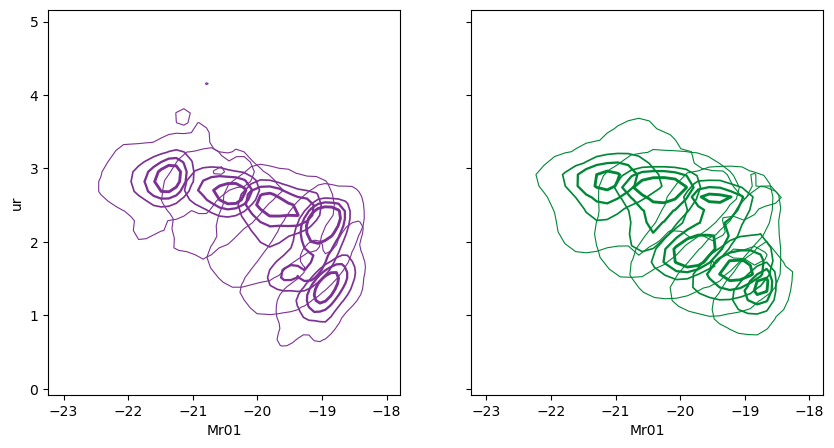

In [68]:
# Veamos algunos contornos...
# logM vs ur
GRID = 30
LEVELS = 3
LWS = np.linspace(0.8,2.5,LEVELS)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)

for b, S_star in mstar.items():
    sns.kdeplot(
        ax=ax1, 
        data=S_star[CL], 
        x='Mr01', 
        y='ur', 
        weights='w', 
        levels=LEVELS, 
        gridsize=GRID, 
        linewidths=LWS, 
        color=COLORS[CL]
    )
    sns.kdeplot(
        ax=ax2, 
        data=S_star[FD], 
        x='Mr01', 
        y='ur', 
        weights='w', 
        levels=LEVELS, 
        gridsize=GRID, 
        linewidths=LWS, 
        color=COLORS[FD]
    )

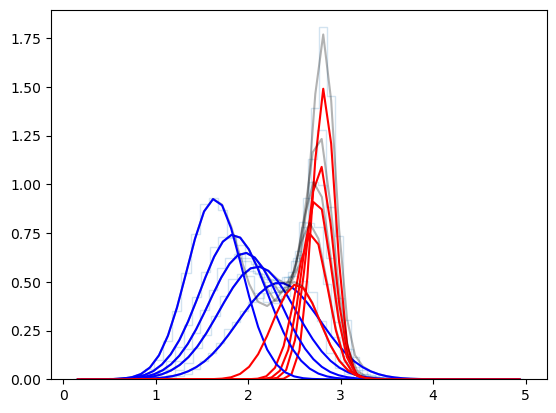

In [35]:
m, f = fitbimodal_quantiles(S[FD], col_fit='ur', col_q='Mr01', nquantiles=5)
for fi in f:
    plt.stairs(fi['y'], fi['xedges'], color='C0', alpha=0.2)
    plt.plot(fi['x'], fi['yfit'], c='k', alpha=0.3)
    plt.plot(fi['x'], fi['popt'][0]*normal(fi['x'], fi['popt'][1], fi['popt'][2]), c='b')
    plt.plot(fi['x'], fi['popt'][3]*normal(fi['x'], fi['popt'][4], fi['popt'][5]), c='r')